# Visualize Inferno Crater data for pseudo-production monitoring purposes

This is used because the old, experimental data logger has been turned off, and the LRDCP pilot is being used instead. Data are stored in a development S3 bucket as AWS. Data retrieval from AWS requires MFA so full automation of this process is not possible.

_Application_

This will be used until the LRDCP is production-ised, and an end-user data access mechanism is available.

_Visualization_

This is intended as a repacement for an old plot using data from the old logger. It shows the same information, though the plot order is slighty different. Time length is 100 days (old was 80). This is facilitated by a 14 week interval. This was chosen to ensure we see at least two overlfows, in the event that overflows are very widely spaced.

_Calculation_

Flow rate in the overflow channel is calculated from water level and is shown.

_Out of Scope_

This is not a 'trouble shooting' visualization. It does not show battery voltage, water level in the overflow channel, difference in temperature measured between the crater water and water in the overflow channel (when overflowing). They are shown in separate xisualizations for 'checking' and 'debugging' field sites.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import boto3
import os
import glob
import shutil
from datetime import datetime, timedelta

In [2]:
def remove_duplines(tmpfile, completefile):
    lines_seen = [] # holds lines already seen
    outfile = open(completefile, 'w')
    for line in open(tmpfile, 'r'):
        if line not in lines_seen: # not a duplicate
            outfile.write(line)
            lines_seen.append(line)
    outfile.close()

In [3]:
@np.vectorize
def flow(x):
    if (x<0):
        flow = 0
    else:
        flow = (1.056*x**1.538)*1000
    return flow

## Date range, last 100 days (14 weeks)

In [4]:
past = datetime.utcnow() - timedelta(weeks=14)
now = datetime.utcnow()

#start of useable data, whole days
datastart = datetime(2019,10,10)

start = max(datastart,past)

date1 = start.strftime('%Y%m%d')
date2 = now.strftime('%Y%m%d')
print (date1, date2)

20191125 20200302


## Get LRDCP pilot data from AWS

In [5]:
#authentication for S3
sts_client = boto3.client('sts')

mfa_TOTP = input("Enter the MFA code: ")

# Call the assume_role method of the STSConnection object and pass the role
# ARN and a role session name.
assumed_role_object=sts_client.assume_role(
    RoleArn="arn:aws:sts::615890063537:role/S3UserRole",
    RoleSessionName="DataLoggerRole",
    SerialNumber="arn:aws:iam::582058524534:mfa/sherburn",
    TokenCode=mfa_TOTP
)

# From the response that contains the assumed role, get the temporary 
# credentials that can be used to make subsequent API calls
credentials=assumed_role_object['Credentials']

s3=boto3.resource('s3',
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken'],
)

Enter the MFA code:  476394


In [6]:
#S3 bucket name
bucket = 'dev-data-logger-lake.geonet.org.nz'

#folder for downloaded daily CSV files
dltmp = '/home/sherburn/GeoNet/datalogger/inferno_monitoring/tmp'
#top folder to save final CSV files
dlsav = '/home/sherburn/GeoNet/datalogger/inferno_monitoring'

#temporary file, concatenated but with daily headers
tmpfile = os.path.join(dlsav, 'tmpfile.csv')

#logger to download data from
logger = 'infernocratertest'

In [7]:
#construct and format the range of dates
dr = pd.date_range(date1, date2, freq='D', )
dates = dr.map(lambda x: x.strftime('%Y/%m/%d'))

In [8]:
os.makedirs(dltmp, exist_ok=True) #make tmp directory for downloaded files
#loop for each date
for date in dates:
    date2 = (datetime.strptime(date, '%Y/%m/%d')).strftime('%Y%m%d')
    s3file = date+'/'+'logger-'+logger+'_Table1'+'_'+date2+'.csv'
    #print (s3file)
    savefile = 'logger-'+logger+'_Table1'+'_'+date2+'.csv'
    try:
        s3.Bucket(bucket).download_file(s3file, os.path.join(dltmp, savefile))
    except:
        print ('fail to download '+s3file)
        pass

#concat all files for the logger
concatfile = tmpfile
files = glob.glob(os.path.join(dltmp, '*.csv'))
files.sort() #to get data in time order
with open(concatfile, 'w') as outfile:
    for file in files:
        with open(file, 'r') as readfile:
            shutil.copyfileobj(readfile, outfile)

shutil.rmtree(dltmp)#remove tmp directory for downloaded files

#remove unwanted header lines from temporary file
completefile = os.path.join(dlsav, logger+'_Table1.csv')
remove_duplines(tmpfile, completefile)
#remove temporary file
os.remove(tmpfile)

fail to download 2020/03/02/logger-infernocratertest_Table1_20200302.csv


### LRDCP pilot data into a dataframe

In [9]:
data = (pd.read_csv(completefile,
        usecols=['Time', 'Depth_USGS_OTT_meters', 'RadarDistance_Meters', 'Temp_thermocouple1_degC', 'Temp_thermocouple2_degC'],
        parse_dates=True,
        index_col='Time'))
data.columns = ['crater_water_level', 'overflow_water_level', 'crater_water_temperature', 'overflow_water_temperature']

In [10]:
#for this test dataset, trim to remove some rubbish at start
data = data.loc['2019-10-11 00:50:00':]

### Calculate crater water level relative to overflow and outflow flowrate

- Adjust water level in crater so that at overflow it is ~10 cm above. Measure in metres below overflow, which is a positive number
- Calcuate flow rate in the overflow channel from overflow depth 

In [11]:
data['crater_water_level_reloverflow'] = (10.1 - data['crater_water_level'])

In [12]:
#for overflow, max measured distance is 'zero' water depth
maxdist = data['overflow_water_level'].max()
data['overflow_water_depth'] = maxdist - data['overflow_water_level']

In [13]:
#calculate overflow rate from water depth in overflow channel
data['overflow_rate'] = flow(data['overflow_water_depth'])

In [14]:
data.tail()

,crater_water_level,overflow_water_level,crater_water_temperature,overflow_water_temperature,crater_water_level_reloverflow,overflow_water_depth,overflow_rate
Time,,,,,,,
2020-03-01 23:10:00+00:00,8.50,1.316,61.410000,20.889999,1.60,0.013,1.327116
2020-03-01 23:20:00+00:00,8.49,1.316,61.360001,21.290001,1.61,0.013,1.327116
2020-03-01 23:30:00+00:00,8.50,1.316,61.230000,21.480000,1.60,0.013,1.327116
2020-03-01 23:40:00+00:00,8.49,1.316,61.230000,21.110001,1.61,0.013,1.327116
2020-03-01 23:50:00+00:00,8.49,1.316,61.340000,21.410000,1.61,0.013,1.327116


### Timing information for title

In [15]:
lastdata = data.index[-1].strftime("%Y-%m-%d %H:%M:%S")

now = datetime.now()
runtime = now.strftime("%Y-%m-%d %H:%M:%S")

### Visualize

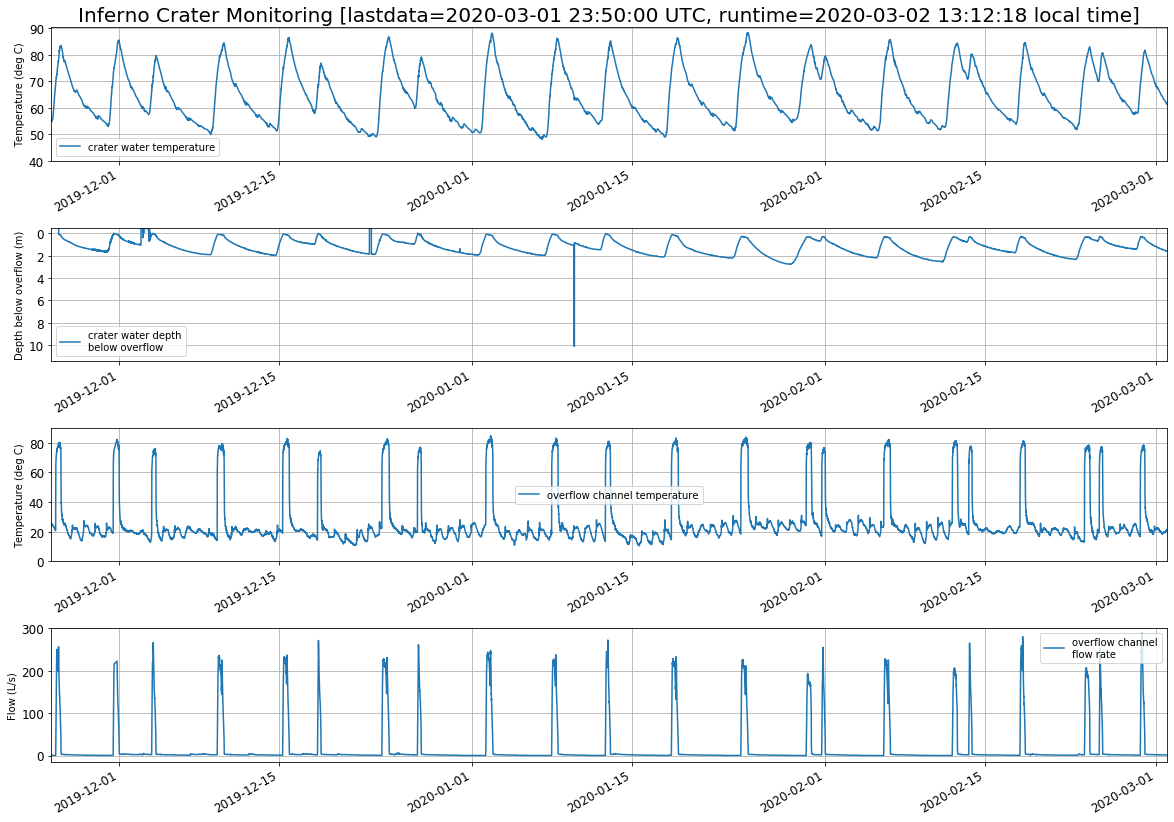

In [16]:
fig,(ax0,ax1,ax2,ax3) = plt.subplots(4, 1, figsize=(20,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

data['crater_water_temperature'].plot(ax=ax0, title='Inferno Crater Monitoring [lastdata='+lastdata+' UTC, runtime='+runtime+' local time]', fontsize=12, label='crater water temperature')
ax0.title.set_size(20)
ax0.grid()
ax0.set_ylabel('Temperature (deg C)')
ax0.set_xlabel('')
ax0.set_ylim(bottom=40)
ax0.legend(loc='best')

data['crater_water_level_reloverflow'].plot(ax=ax1, fontsize=12, label='crater water depth\nbelow overflow')
ax1.title.set_size(20)
ax1.grid()
ax1.set_ylabel('Depth below overflow (m)')
ax1.set_xlabel('')
ax1.set_ylim(bottom=-0.5)
ax1.invert_yaxis()
ax1.legend(loc='best')

data['overflow_water_temperature'].plot(ax=ax2, label='overflow channel temperature', fontsize=12)
ax2.title.set_size(20)
ax2.grid()
ax2.set_ylabel('Temperature (deg C)')
ax2.set_xlabel('')
ax2.legend(loc='best')
ax2.set_ylim(bottom=0,top=90)

data['overflow_rate'].plot(ax=ax3, label='overflow channel\nflow rate', fontsize=12)
ax3.title.set_size(20)
ax3.grid()
ax3.set_ylabel('Flow (L/s)')
ax3.set_xlabel('')
ax3.legend(loc='best')
ax3.set_ylim(top=300)

fig.savefig('inferno_monitoring.png', dpi=100, bbox_inches='tight')